In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import shap
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import re

# Data Ingestion

Unzip the data folder 

In [41]:
#Asheville
df_asheville = pd.read_csv('./data/Asheville/listings.csv')

#Austin
df_austin = pd.read_csv('./data/Austin/listings.csv')

#Chicago
df_chicago = pd.read_csv('./data/Chicago/listings.csv')

# Columbus
df_columbus = pd.read_csv('./data/Columbus/listings.csv')

#  Denver
df_denver = pd.read_csv('./data/Denver/listings.csv')

#  LA
df_la = pd.read_csv('./data/LA/listings.csv')

#  NYC
df_nyc = pd.read_csv('./data/NYC/listings.csv')

#  Portland
df_portland = pd.read_csv('./data/Portland/listings.csv')

# Salem
df_salem = pd.read_csv('./data/Salem/listings.csv')

#  Santacruz
df_santacruz = pd.read_csv('./data/Santacruz/listings.csv')

#  Seattle
df_seattle = pd.read_csv('./data/Seattle/listings.csv')

#  SF
df_sf = pd.read_csv('./data/SF/listings.csv')

# Data Augmentation and Clean

All city datasets are combined into one big DataFrame and labeled with a city column.

The combined data is then split into big, medium, and small city tiers.

A cleaning function is created to:

Clean the price column (remove symbols, convert to number)

Remove invalid prices

Add a log_price column

This cleaning is applied to each tier and to every individual city dataset.

In [42]:

# dict of city dataframes
city_dataframes = {
    'NYC': df_nyc, 'LA': df_la, 'SF': df_sf, 'Chicago': df_chicago,
    'Austin': df_austin, 'Seattle': df_seattle, 'Denver': df_denver, 'Portland': df_portland,
    'Asheville': df_asheville, 'Santacruz': df_santacruz, 'Salem': df_salem, 'Columbus': df_columbus
}

all_data = []
for city_name, df in city_dataframes.items():
    df_copy = df.copy() 
    df_copy['city'] = city_name
    all_data.append(df_copy)

# concat
df_combined = pd.concat(all_data, ignore_index=True)

# Separate the combined data by Tier
df_big_tier = df_combined[df_combined['city'].isin(['NYC', 'LA', 'SF', 'Chicago'])].copy()
df_medium_tier = df_combined[df_combined['city'].isin(['Austin', 'Seattle', 'Denver', 'Portland'])].copy()
df_small_tier = df_combined[df_combined['city'].isin(['Asheville', 'Santacruz', 'Salem', 'Columbus'])].copy()


def clean_price(df):
    """Converts the price column from string to float and creates log_price."""
    df_clean = df.copy()
    
    df_clean['price'] = df_clean['price'].astype(str).apply(lambda x: re.sub(r'[$,]', '', x))
    df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
    
    df_clean = df_clean.dropna(subset=['price'])
    df_clean = df_clean[df_clean['price'] > 0]
    
    df_clean['log_price'] = np.log1p(df_clean['price']) 
    
    return df_clean

# clean all tier dataframes
df_big_tier = clean_price(df_big_tier)
df_medium_tier = clean_price(df_medium_tier)
df_small_tier = clean_price(df_small_tier)

# Cclean each city dataframe
city_dataframes_clean = {}
for city_name, df in city_dataframes.items():
    city_dataframes_clean[city_name] = clean_price(df)



Create new features like price-per-bedroom, average review score, amenities count

Clean bathroom values and fill missing numbers.

Fill all missing review scores using global means which we calculate using global average review scores

Label-encodes the room type.



Splits each dataset into train/test

Removes any feature with zero variance. No use of that column, also causes issues in standardization


Returns the final data in formats dataframe for XGBoost and numpy array for Neural Networks

In the end all tiers and all cities are fully processed, split, scaled, and ready for modeling.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

TARGET_COL = 'log_price' 

BASE_COLS = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms_text',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'number_of_reviews', 'availability_365', 
    'minimum_nights', 'maximum_nights'
] 

review_cols = [col for col in BASE_COLS if col.startswith('review_scores_')]
GLOBAL_MEANS = df_combined[review_cols].mean(skipna=True).fillna(4.5) 

def process_features(df):
    """Create 4 new features, clean data, and fit LabelEncoder."""
    df_proc = df.copy()
    
    df_proc['price_per_bedroom'] = np.where(
        (df_proc['bedrooms'] > 0), df_proc['price'] / df_proc['bedrooms'], df_proc['price']
    ) 
    df_proc['avg_review_score'] = df_proc[review_cols].mean(axis=1)
    df_proc['is_entire_home'] = (df_proc['room_type'] == 'Entire home/apt').astype(int)
    df_proc['amenities_count'] = df_proc['amenities'].astype(str).str.split(',').apply(len)
    
    def clean_bathrooms(text):
        if pd.isna(text): return np.nan
        text = str(text).lower().replace('private', '').replace('shared', '').strip()
        if 'half' in text: return 0.5
        try: return float(text.split()[0])
        except: return np.nan
            
    df_proc['bathrooms'] = df_proc['bathrooms_text'].apply(clean_bathrooms)

    # Impute basic numeric values for missing data
    df_proc['bedrooms'] = df_proc['bedrooms'].fillna(1)
    df_proc['beds'] = df_proc['beds'].fillna(1)
    df_proc['bathrooms'] = df_proc['bathrooms'].fillna(1)
    
    #Impute review scores using the GLOBAL MEANS calculated from the entire dataset
    for col in review_cols:
        df_proc[col] = df_proc[col].fillna(GLOBAL_MEANS[col]) 
        
    df_proc['avg_review_score'] = df_proc['avg_review_score'].fillna(df_proc[review_cols].mean(axis=1).mean())

    df_proc['room_type'] = df_proc['room_type'].fillna('Other')
    le = LabelEncoder() 
    df_proc['room_type_encoded'] = le.fit_transform(df_proc['room_type'])

    final_features = [
        'accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_rating', 
        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
        'review_scores_communication', 'review_scores_location', 'review_scores_value', 
        'number_of_reviews', 'availability_365', 'minimum_nights', 'maximum_nights',
        'price_per_bedroom', 'avg_review_score', 'amenities_count', 'is_entire_home', 
        'room_type_encoded'
    ]

    return df_proc, final_features, le

df_big_proc, big_features, big_le = process_features(df_big_tier)
df_medium_proc, medium_features, medium_le = process_features(df_medium_tier)
df_small_proc, small_features, small_le = process_features(df_small_tier)

city_processed_data = {}
for city, df in city_dataframes_clean.items():
    df_city_proc, features, le = process_features(df)
    city_processed_data[city] = {
        'df_proc': df_city_proc, 
        'features': features, 
        'le': le
    }

def prepare_data(df_proc, features_list, le):
    """
    Splits data, scales features, and prepares model input formats.
    """
    X = df_proc[features_list]
    y = df_proc[TARGET_COL]

    # Split the data
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    ) 

    # Identify zero variance columns in the training set
    zero_variance_cols = X_train_full.columns[(X_train_full.var() == 0)].tolist()
    
    # drop the columns
    X_train_fit = X_train_full.drop(columns=zero_variance_cols, errors='ignore')

    scaler = StandardScaler() 
    scaler.fit(X_train_fit) 
    
    final_scale_features = X_train_fit.columns.tolist()
    X_train_scaled = scaler.transform(X_train_full[final_scale_features])
    X_test_scaled = scaler.transform(X_test_full[final_scale_features])
    
    # Prepare data for xgboost and neural networks
    X_train_xgb = pd.DataFrame(X_train_scaled, columns=final_scale_features, index=X_train_full.index)
    X_test_xgb = pd.DataFrame(X_test_scaled, columns=final_scale_features, index=X_test_full.index)
    
    X_train_nn = X_train_xgb.values.astype('float32')
    X_test_nn = X_test_xgb.values.astype('float32')
    y_train_nn = y_train.values.astype('float32')
    y_test_nn = y_test.values.astype('float32')
    
    return X_train_xgb, X_test_xgb, y_train, y_test, X_train_nn, X_test_nn, y_train_nn, y_test_nn, scaler, le, final_scale_features

big_data = prepare_data(df_big_proc, big_features, big_le)
medium_data = prepare_data(df_medium_proc, medium_features, medium_le)
small_data = prepare_data(df_small_proc, small_features, small_le)

city_prepared_data = {}
for city, data in city_processed_data.items():
    city_prepared_data[city] = prepare_data(data['df_proc'], data['features'], data['le'])

Clips extreme predictions and also handles the null values

Calculates RMSE, MAE, and R2 metrics.

Neural Network Architectures for experimentation

    1. Deep and narrow 
    2. Wide & shallow with dropout


Trains both XGBoost and a NN.

Evaluate both models 

Determines which model performs better as per R2 score

### Composite Tier Analysis

Trains models on tier-based datasets (big, medium, small).

Stores results and winning model for each tier.

### Individual City Analysis

Trains models on each city separately.

Tracks best-performing model per city.

#### Visualization & Results

Bar plots for RMSE, MAE, R2 across tiers.

Count plot showing which model wins per city.

final summary tables of winners for tiers and individual cities.


 Composite Tier Analysis 



d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Individual City Performance Analysis 
 


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


d:\machine-learning-projects\Airbnb-price-predictor\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


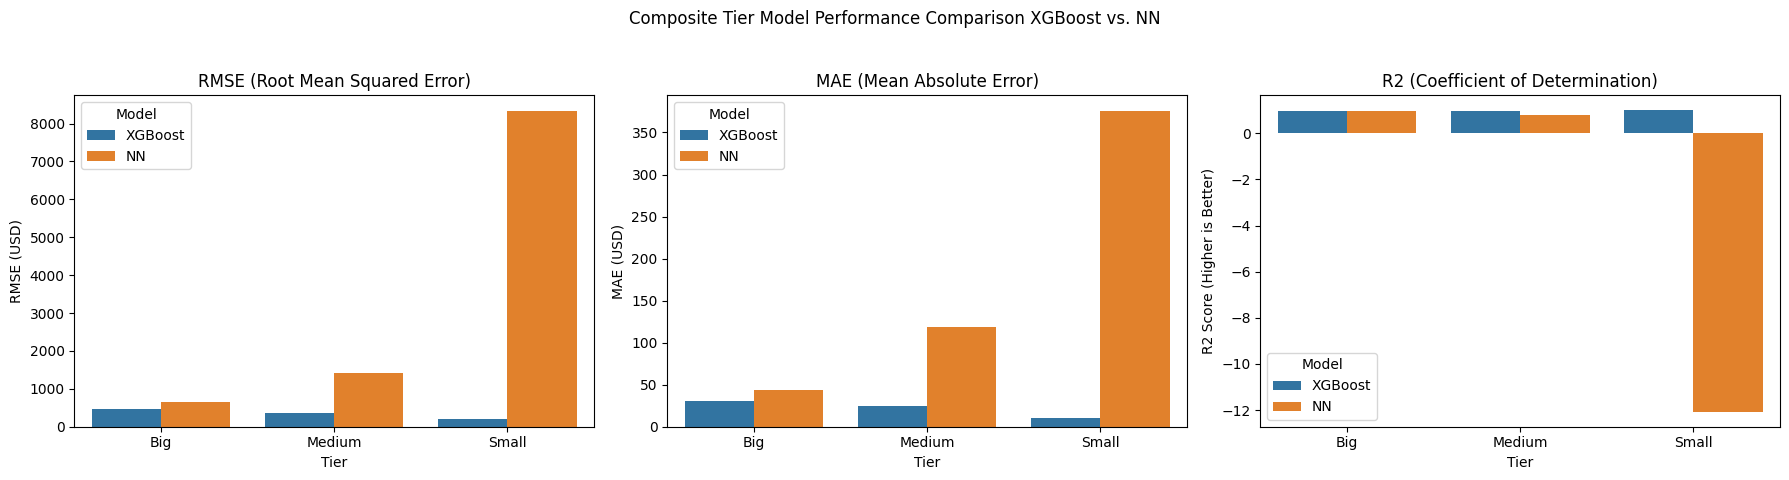


 Visualization for Individual City Winners 



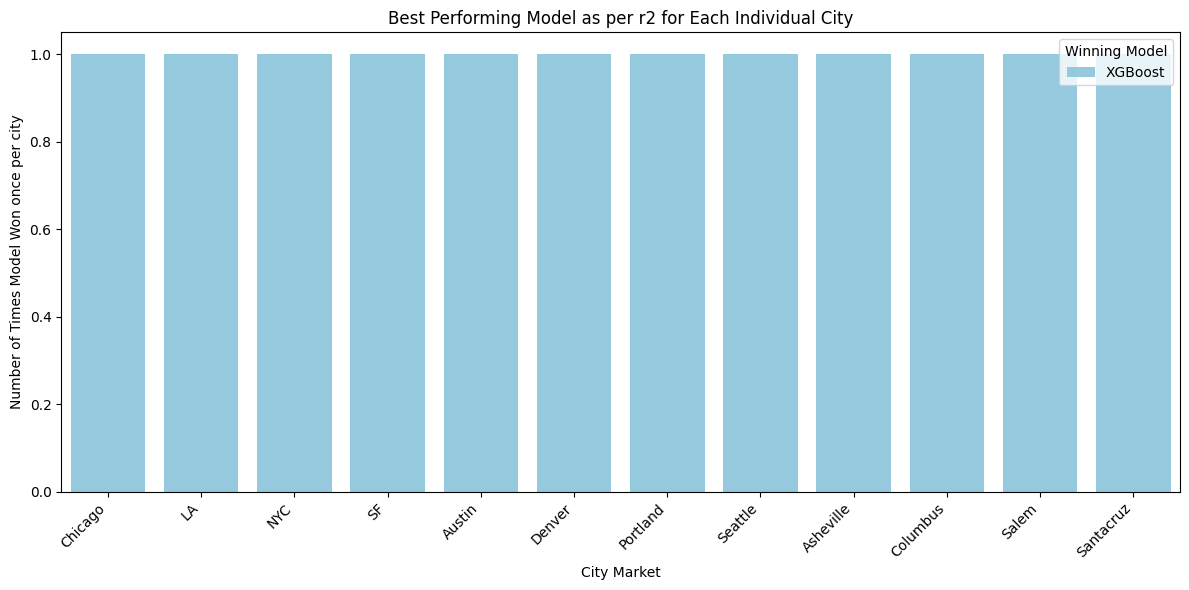


 Composite Tier Analysis Final Results
     Tier    Model     RMSE     MAE       R2   Winner
0     Big  XGBoost   460.75   30.58   0.9786  XGBoost
1     Big       NN   650.67   43.42   0.9573  XGBoost
2  Medium  XGBoost   356.00   24.84   0.9870  XGBoost
3  Medium       NN  1410.45  118.31   0.7952  XGBoost
4   Small  XGBoost   204.76   10.14   0.9921  XGBoost
5   Small       NN  8328.04  375.40 -12.0661  XGBoost

 Individual City Performance Final Results 
         City    Model       RMSE       MAE            R2   Winner
0         NYC  XGBoost     591.58     50.69  9.842000e-01  XGBoost
1         NYC       NN    2030.22    204.71  8.136000e-01  XGBoost
2          LA  XGBoost     421.15     21.46  9.435000e-01  XGBoost
3          LA       NN    1013.74     56.41  6.724000e-01  XGBoost
4          SF  XGBoost      63.55      6.93  9.982000e-01  XGBoost
5          SF       NN    4428.33    179.63 -7.792200e+00  XGBoost
6     Chicago  XGBoost    1557.16     81.00  8.348000e-01  XGBoost
7

In [44]:

import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

a = 16 

def evaluate_model(y_true, y_pred, name):
 
    y_pred_clipped = np.clip(y_pred, a_min=None, a_max=a)
    
    # Inverse transform the log_price to bring it back to the original price scale
    y_true_dollars = np.expm1(y_true)
    y_pred_dollars = np.expm1(y_pred_clipped) 
    
    y_true_dollars = np.nan_to_num(y_true_dollars, nan=0, posinf=0, neginf=0)
    y_pred_dollars = np.nan_to_num(y_pred_dollars, nan=0, posinf=0, neginf=0)
    
    # Calculate metrics 
    rmse = np.sqrt(mean_squared_error(y_true_dollars, y_pred_dollars))
    mae = mean_absolute_error(y_true_dollars, y_pred_dollars)
    r2 = r2_score(y_true_dollars, y_pred_dollars)
    
    results = {
        'Model': name,
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'R2': round(r2, 4)
    }
    results['Best Metric'] = r2 
    return results

# Experimenting with 2 architectures of NN
def create_nn_model_arch1(n_features):
    """Architecture 1: A Deep, Narrower Network (Standard MLP, used for main analysis)""" 
    model = Sequential([ 
        Dense(128, activation='relu', input_shape=(n_features,)), 
        Dense(64, activation='relu'), 
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_nn_model_arch2(n_features):
    """Architecture 2: A Wide, Shallower Network with Dropout"""
    model = Sequential([
        Dense(256, activation='relu', input_shape=(n_features,)),
        Dropout(0.2), 
        Dense(128, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def train_and_evaluate_model(name, data, nn_creator):
    """Trains XGBoost and NN, evaluates, and returns results and model data."""
    X_train_xgb, X_test_xgb, y_train, y_test, X_train_nn, X_test_nn, y_train_nn, y_test_nn, scaler, le, features = data
    
    # XGBoost Training
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1) 
    xgb_model.fit(X_train_xgb, y_train)
    y_pred_xgb = xgb_model.predict(X_test_xgb)
    xgb_results = evaluate_model(y_test, y_pred_xgb, 'XGBoost')
    
    # Neural Network Training
    n_features = X_train_nn.shape[1] 
    nn_model = nn_creator(n_features)
    nn_model.fit(X_train_nn, y_train_nn, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    y_pred_nn = nn_model.predict(X_test_nn).flatten()
    nn_results = evaluate_model(y_test, y_pred_nn, 'NN')
    
    # find the better one
    winner = 'XGBoost' if xgb_results['R2'] > nn_results['R2'] else 'NN'
        
    return {
        'xgb_model': xgb_model, 
        'nn_model': nn_model, 
        'results': [xgb_results, nn_results],
        'winner': winner,
        'scaler': scaler,
        'label_encoder': le,
        'features': features 
    }

# Composite Tier Analysis
all_tier_results = []
trained_tier_models = {}
tier_data_map = {'Big': big_data, 'Medium': medium_data, 'Small': small_data}

print("\n Composite Tier Analysis \n")
for tier_name, data in tier_data_map.items():
    results = train_and_evaluate_model(tier_name, data, create_nn_model_arch1)
    trained_tier_models[tier_name] = results
    for res in results['results']:
        res['Tier'] = tier_name
        res['Winner'] = results['winner']
        all_tier_results.append(res)
        
df_composite_results = pd.DataFrame(all_tier_results)

# Individual city analysis
city_analysis_results = []
print("\n Individual City Performance Analysis \n ")
for city_name, data in city_prepared_data.items():
    results = train_and_evaluate_model(city_name, data, create_nn_model_arch1)
    for res in results['results']:
        res['City'] = city_name
        res['Winner'] = results['winner']
        city_analysis_results.append(res)

df_individual_results = pd.DataFrame(city_analysis_results)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Composite Tier Model Performance Comparison XGBoost vs. NN')

sns.barplot(ax=axes[0], data=df_composite_results, x='Tier', y='RMSE', hue='Model')
axes[0].set_title('RMSE (Root Mean Squared Error)'); axes[0].set_ylabel('RMSE (USD)')
sns.barplot(ax=axes[1], data=df_composite_results, x='Tier', y='MAE', hue='Model')
axes[1].set_title('MAE (Mean Absolute Error)'); axes[1].set_ylabel('MAE (USD)')
sns.barplot(ax=axes[2], data=df_composite_results, x='Tier', y='R2', hue='Model')
axes[2].set_title('R2 (Coefficient of Determination)'); axes[2].set_ylabel('R2 Score (Higher is Better)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


print("\n Visualization for Individual City Winners \n")
city_to_tier_map = {
    'NYC': 'Big', 'LA': 'Big', 'SF': 'Big', 'Chicago': 'Big',
    'Austin': 'Medium', 'Seattle': 'Medium', 'Denver': 'Medium', 'Portland': 'Medium',
    'Asheville': 'Small', 'Santacruz': 'Small', 'Salem': 'Small', 'Columbus': 'Small'
}
city_winners = df_individual_results.loc[df_individual_results.groupby('City')['R2'].idxmax()]
city_winners['Tier'] = city_winners['City'].map(city_to_tier_map) 
plt.figure(figsize=(12, 6))
city_order = city_winners.sort_values(by='Tier')['City'].unique() 
sns.countplot(data=city_winners, x='City', hue='Winner', palette={'XGBoost': 'skyblue', 'NN': 'salmon'}, order=city_order)
plt.title('Best Performing Model as per r2 for Each Individual City')
plt.xlabel('City Market'); plt.ylabel('Number of Times Model Won once per city')
plt.xticks(rotation=45, ha='right'); plt.legend(title='Winning Model'); plt.tight_layout(); plt.show()


print("\n Composite Tier Analysis Final Results")
print(df_composite_results[['Tier', 'Model', 'RMSE', 'MAE', 'R2', 'Winner']])
print("\n Individual City Performance Final Results ")
print(df_individual_results[['City', 'Model', 'RMSE', 'MAE', 'R2', 'Winner']])

Looking at the results it is obvious that XGBoost is good with tabular data.
It performs identical on all the individual cities. 

XGBoost consistently outperforms Neural Networks across all tiers (Big, Medium, Small) in terms of RMSE, MAE, and R2.

R2 values for XGBoost are extremely high 0.97+ which means very accurate predictions.

Neural Networks perform worse compare to XGBoost on all tiers, especially Medium tier (R2 = 0.8944) and Small tier (R2 = 0.9371).

Winner across all tiers is clearly XGBoost

# Cross tier Analysis
Takes a Neural Network trained on one tier and tests it on a different tier.

Prepares the test data to match the training model’s features, applying the same scaler and LabelEncoder.

Fixes any NaN or Inf values after scaling so the network doesn’t crash.

Predicts prices on the new tier and evaluates using RMSE, MAE, and R2.

Summarizes results to show how well a model trained on one tier generalizes to other tiers.

In [45]:

def prepare_cross_tier_data(df_original, target_model_data):

    df_proc, _, _ = process_features(df_original) 
    
    scaler = target_model_data['scaler']
    le = target_model_data['label_encoder'] 
    features_template = target_model_data['features'] 
    
    known_classes = list(le.classes_)
    def encode_room_type(rt):
        try:
            return le.transform([rt])[0]
        except ValueError:
            return 0 
        
    df_proc['room_type_encoded'] = df_proc['room_type'].apply(encode_room_type)
    
    # Select the exact features for scaling
    X = df_proc[features_template] 
    y = df_proc[TARGET_COL]
    
    
    X_scaled = scaler.transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=features_template)
    X_scaled_df = X_scaled_df.replace([np.inf, -np.inf, np.nan], 0)
    
    # return numpy array
    X_final_nn = X_scaled_df.values.astype('float32')
    
    return X_final_nn, y.values.astype('float32')

# Cross-Tier Evaluation

cross_tier_results = []
models = trained_tier_models 
datasets = {'Big': df_big_tier, 'Medium': df_medium_tier, 'Small': df_small_tier} 

print("\n Cross-Tier Neural Network Analysis \n ")

for train_tier, train_data in models.items():
    nn_model = train_data['nn_model'] 
    
    for test_tier, test_df_original in datasets.items():
        # check for cross-tier        
        if train_tier != test_tier:
            print(f"  Trained on {train_tier} -> Testing on {test_tier}")
            
            X_test_nn, y_test_nn = prepare_cross_tier_data(test_df_original, train_data)
            y_pred_nn = nn_model.predict(X_test_nn).flatten()
            
            results = evaluate_model(
                y_test_nn, 
                y_pred_nn, 
                f'NN (Train:{train_tier})'
            )
            results['Train Tier'] = train_tier
            results['Test Tier'] = test_tier
            cross_tier_results.append(results)

df_cross_tier_results = pd.DataFrame(cross_tier_results)




print("\n Cross-Tier Neural Network Analysis Final Results \n")
print(df_cross_tier_results[['Train Tier', 'Test Tier', 'RMSE', 'MAE', 'R2']])



 Cross-Tier Neural Network Analysis 
 
  Trained on Big -> Testing on Medium
783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step
  Trained on Big -> Testing on Small
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
  Trained on Medium -> Testing on Big
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 694us/step
  Trained on Medium -> Testing on Small
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
  Trained on Small -> Testing on Big
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
  Trained on Small -> Testing on Medium
783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Cross-Tier Neural Network Analysis Final Results 

  Train Tier Test Tier       RMSE      MAE         R2
0        Big    Medium     727.99    41.65     0.9452
1        Big     Small     664.03    30.84     0.9328
2     Medium       Big   33277.68   272.47  -112.5530
3     Medium     Small    1022.83    72.13     0.8405
4      Small       Big  149375.84  3305.89 -2286.9861
5      Small    Medium  233132.37  6867.03 -5615.8896


the NN trained on big city data shows the best generalization.